In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dfAll = pd.read_csv('one piece arcs.csv')
dfAll.head()

,Arc Name,Arc Type,Total Chapters,Manga Percentage,Total Episodes,Total Minutes,Anime Percentage
0,Romance Dawn Arc,Canon,7,0.0067,3,72,0.0028
1,Orange Town Arc,Canon,14,0.0133,5,120,0.0046
2,Syrup Village Arc,Canon,20,0.0191,10,240,0.0093
3,Baratie Arc,Canon,27,0.0257,12,288,0.0112
4,Arlong Park Arc,Canon,27,0.0257,14,360,0.0130


Добавляем новый атрибут - отношение числа глав в манге к числу серий в адаптации

In [4]:
dfAll['Ratio of chapters and episodes'] = dfAll['Total Chapters']/dfAll['Total Episodes']

In [5]:
dfAll.head()

,Arc Name,Arc Type,Total Chapters,Manga Percentage,Total Episodes,Total Minutes,Anime Percentage,Ratio of chapters and episodes
0,Romance Dawn Arc,Canon,7,0.0067,3,72,0.0028,2.333333
1,Orange Town Arc,Canon,14,0.0133,5,120,0.0046,2.800000
2,Syrup Village Arc,Canon,20,0.0191,10,240,0.0093,2.000000
3,Baratie Arc,Canon,27,0.0257,12,288,0.0112,2.250000
4,Arlong Park Arc,Canon,27,0.0257,14,360,0.0130,1.928571


In [6]:
df=dfAll.drop(columns = ['Arc Name','Arc Type'],axis = 1)

In [7]:
print('Количество строк в датаесе =',df.shape[0])

Количество строк в датаесе = 55


Проверяем, есть ли пропущенные значения

In [8]:
print(df.isnull().sum())

Total Chapters                    0
Manga Percentage                  0
Total Episodes                    0
Total Minutes                     0
Anime Percentage                  0
Ratio of chapters and episodes    0
dtype: int64


Пропущенных значений нет 
</br></br>
Удалим выбросы при помощи межквартильного расстояния. Удаление выбросов с использованием межквартильного расстояния (IQR) — это распространенный метод, основанный на интерквартильном размахе. Интерквартильный размах - это разница между верхним (Q3) и нижним (Q1) квартилями данных. Выбросами считаются точки данных, которые находятся за пределами установленного диапазона, определенного на основе IQR.

In [9]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~(((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1))]

In [10]:
print('Количество строк в датаесе =',df.shape[0])

Количество строк в датаесе = 50


Количество строк в датасете уменьшилось (было 55, стало 50). Значит мы удалили выбросы.

Из-за специфики данных в датасете, повторяющихся значений в них быть не может (т.к. название арки всегда уникально). Если бы у нас был датасет с дупликатами его можно было бы очистить от них при помощи функции drop_duplicates().

Построим графики зависимостей

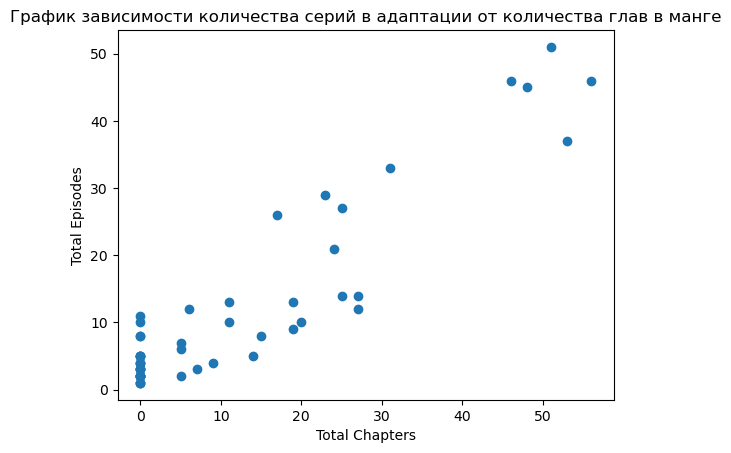

In [11]:
x = 'Total Chapters'
y = 'Total Episodes'
plt.scatter(df[x],df[y])
plt.xlabel(x)
plt.ylabel(y)
plt.title('График зависимости количества серий в адаптации от количества глав в манге')
plt.show()

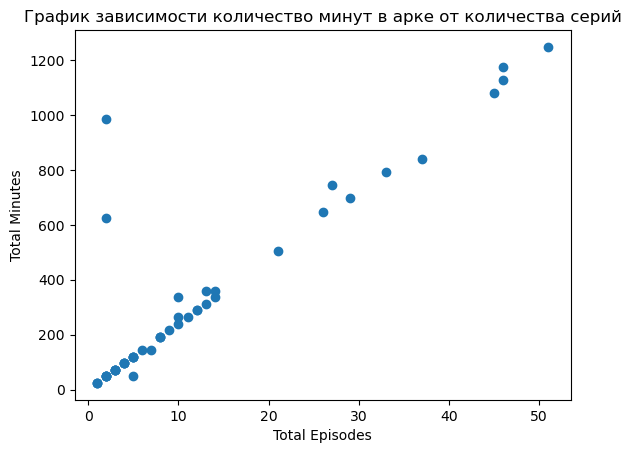

In [12]:
x = 'Total Episodes'
y = 'Total Minutes'
plt.scatter(df[x],df[y])
plt.xlabel(x)
plt.ylabel(y)
plt.title('График зависимости количество минут в арке от количества серий')
plt.show()

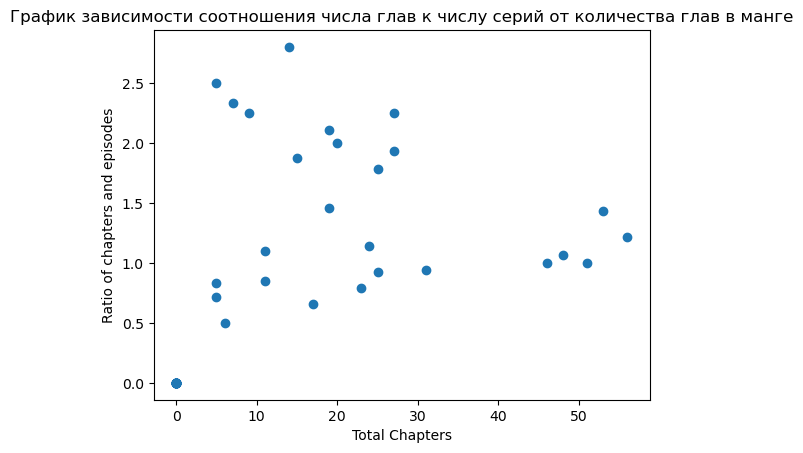

In [13]:
x = 'Total Chapters'
y = 'Ratio of chapters and episodes'
plt.scatter(df[x],df[y])
plt.xlabel(x)
plt.ylabel(y)
plt.title('График зависимости соотношения числа глав к числу серий от количества глав в манге')
plt.show()

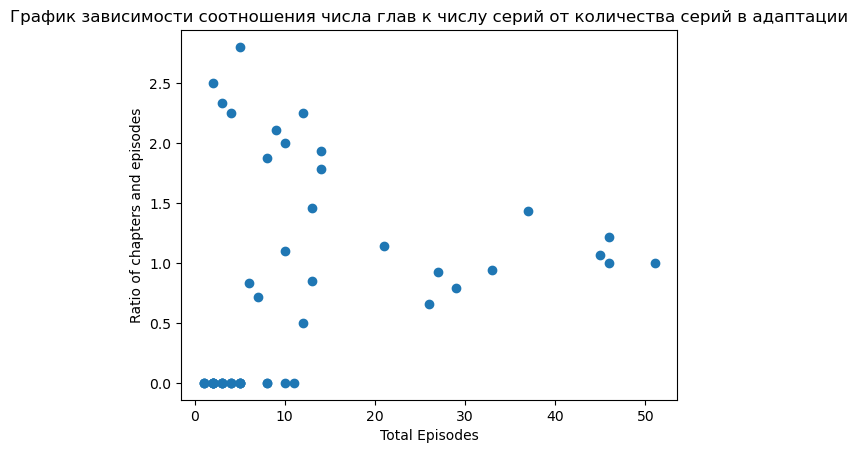

In [14]:
x = 'Total Episodes'
y = 'Ratio of chapters and episodes'
plt.scatter(df[x],df[y])
plt.xlabel(x)
plt.ylabel(y)
plt.title('График зависимости соотношения числа глав к числу серий от количества серий в адаптации')
plt.show()

Попробуем применить к атрибутам метод KMeans.
</br>
Для начала необходимо посчитать оптимальное количество кластеров. Сделать это можно при помощи метода локтя. Вот его алгоритм:
</br>
1) Проведите кластеризацию с разным числом кластеров.
2) Для каждого числа кластеров вычислите сумму квадратов расстояний от каждой точки до центра своего кластера.
3) Постройте график зависимости суммы квадратов расстояний от числа кластеров.
4) Найдите точку "локтя" на графике, где уменьшение внутрикластерного расстояния замедляется. Это может быть хорошим приближением оптимального числа кластеров.

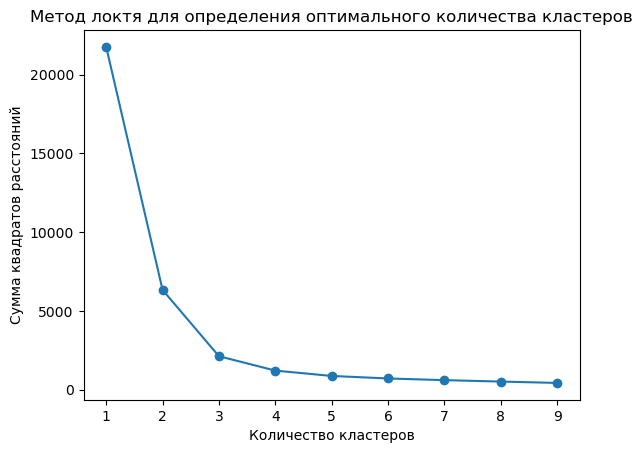

In [15]:
X = df[['Total Chapters','Total Episodes']]

num_clusters = range(1, 10)
inertia = []
for n in num_clusters:
    kmeans = KMeans(n_clusters=n, random_state=0, n_init="auto")
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    
plt.plot(num_clusters, inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Метод локтя для определения оптимального количества кластеров')
plt.show()

Теперь проведем кластеризацию. На график видно, что оптимальное количество кластеров - это 3.

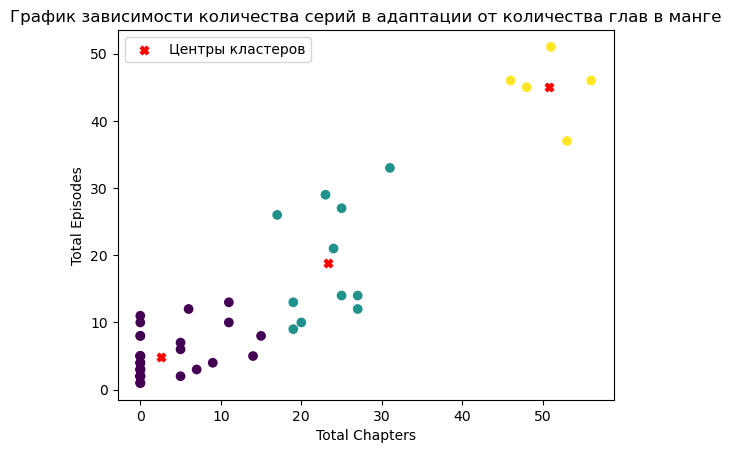

In [16]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X)
labels = kmeans.predict(X)
plt.scatter(X['Total Chapters'], X['Total Episodes'], c=labels)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', c='red', label='Центры кластеров')
plt.xlabel('Total Chapters')
plt.ylabel('Total Episodes')
plt.legend()
plt.title('График зависимости количества серий в адаптации от количества глав в манге')
plt.show()

На графике видно, что данные четко разделились на 3 группы, между ними нет пересечений. 
<br>
Получились следующие кластеры:
1) Фиолетовый - малое количество глав манги и малое количество серий в адаптации
2) Бирюзовый - среднее количество глав манги и среднее количество серий в адаптации
3) Желтый - большое количество глав манги и большое количество серий в адаптации

Полученные данные логичны: чем больше глав было в оригинале, тем больше будет и серий в адаптации.
<br>
Так же сожно сделать вывод о том, что манга и адаптация преимущественно содержит арки короткой и средней длины (до 30 глав/эпизодов).

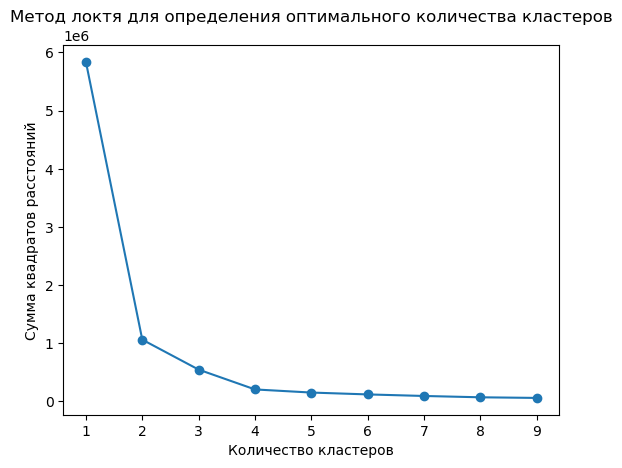

In [17]:
X = df[['Total Episodes','Total Minutes']]
num_clusters = range(1, 10)
inertia = []
for n in num_clusters:
    kmeans = KMeans(n_clusters=n, random_state=0, n_init="auto")
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    
plt.plot(num_clusters, inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Метод локтя для определения оптимального количества кластеров')
plt.show()

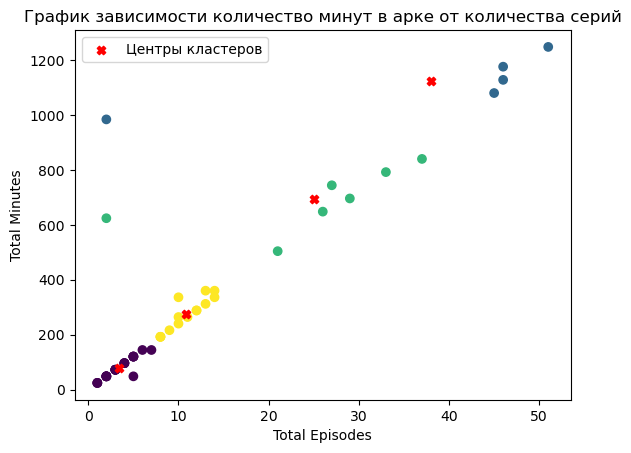

In [18]:

kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X)
labels = kmeans.predict(X)
plt.scatter(X['Total Episodes'], X['Total Minutes'], c=labels)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', c='red', label='Центры кластеров')
plt.xlabel('Total Episodes')
plt.ylabel('Total Minutes')
plt.legend()
plt.title('График зависимости количество минут в арке от количества серий')
plt.show()

На графике видно, что данные четко разделились на 4 группы, однако уже не так хорошо, как в предыдущем случае. Это связано с тем, что притствуют арки с низким количеством серий, но при этом с большой продолжительностью этих самых серий. 
<br>
Получились следующие кластеры:
1) Фиолетовый - малое количество серий и малая суммарная продолжительность
2) Желтый - меньше среднего количество серий и меньше среднего суммарная продолжительность
3) Зеленый - среднее количество серий и средняя суммарная продолжительность
4) Синий - большое количество серий и большая суммарная продолжительность

Полученные данные, так же как и в прошлый раз, логичны.

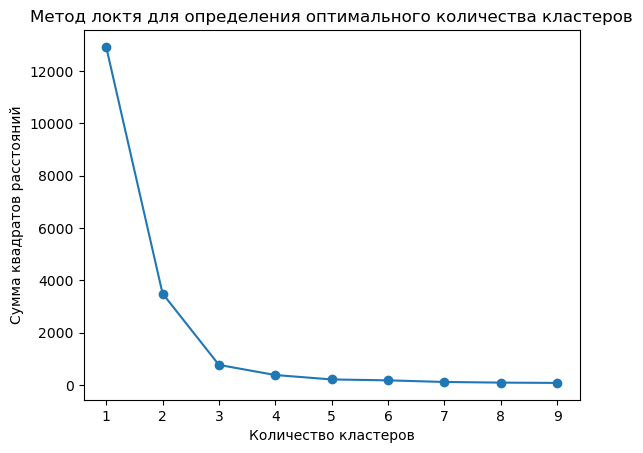

In [19]:
X = df[['Total Chapters','Ratio of chapters and episodes']]
num_clusters = range(1, 10)
inertia = []
for n in num_clusters:
    kmeans = KMeans(n_clusters=n, random_state=0, n_init="auto")
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    
plt.plot(num_clusters, inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Метод локтя для определения оптимального количества кластеров')
plt.show()

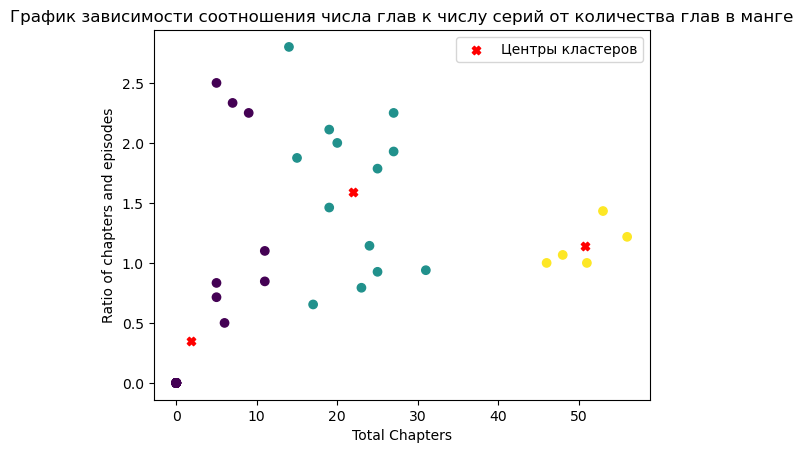

In [20]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X)
labels = kmeans.predict(X)
plt.scatter(X['Total Chapters'], X['Ratio of chapters and episodes'], c=labels)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', c='red', label='Центры кластеров')
plt.xlabel('Total Chapters')
plt.ylabel('Ratio of chapters and episodes')
plt.legend()
plt.title('График зависимости соотношения числа глав к числу серий от количества глав в манге')
plt.show()

Получились следующие кластеры:
1) Фиолетовый - малое количество глав манги и преимущественно малое значение соотношения количества глав манги к количеству серий в адаптации
2) Бирюзовый - среднее количество глав манги и преимущественно высокое значение соотношения количества глав манги к количеству серий в адаптации
3) Желтый - большое количество глав манги и среднее значение соотношения количества глав манги к количеству серий в адаптации

В этот раз данные в кластерах достаточно сильно разбросаны по вертикали от своих центров (кроме желтого).
<br>
По центрам кластеров мы може сделать вывод о том, что короткие арки, как правило, растягивают в адаптации; средние - сжимают; а длинные переносят не сжимая и не растягивая. Таким образом, количество глав в манге и количество серий в адаптации примерно совпадает. 

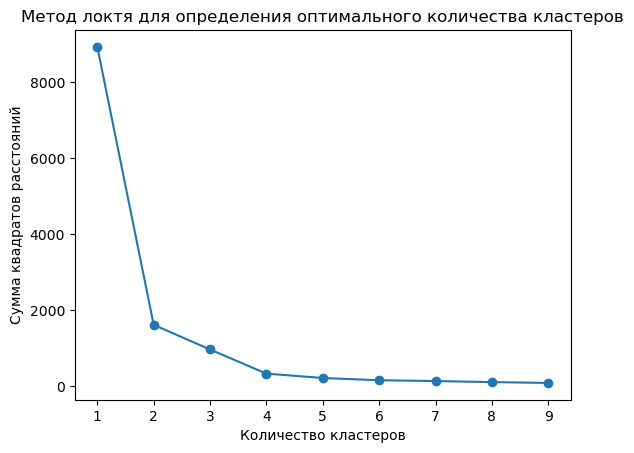

In [21]:
X = df[['Total Episodes','Ratio of chapters and episodes']]
num_clusters = range(1, 10)
inertia = []
for n in num_clusters:
    kmeans = KMeans(n_clusters=n, random_state=0, n_init="auto")
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    
plt.plot(num_clusters, inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Метод локтя для определения оптимального количества кластеров')
plt.show()

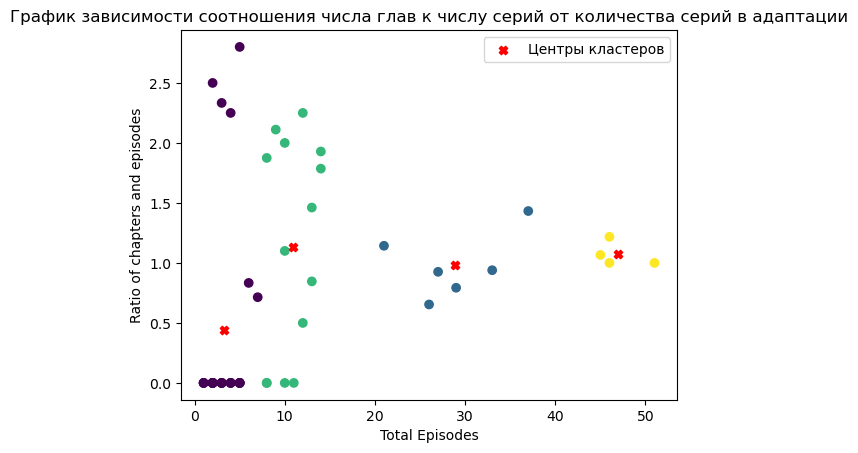

In [22]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X)
labels = kmeans.predict(X)
plt.scatter(X['Total Episodes'], X['Ratio of chapters and episodes'], c=labels)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', c='red', label='Центры кластеров')
plt.xlabel('Total Episodes')
plt.ylabel('Ratio of chapters and episodes')
plt.legend()
plt.title('График зависимости соотношения числа глав к числу серий от количества серий в адаптации')
plt.show()

Получились следующие кластеры:
1) Фиолетовый - малое количество серий и преимущественно малое значение соотношения количества глав манги к количеству серий в адаптации
2) Зеленый - меньше среднего количество серий и среднее значение соотношения количества глав манги к количеству серий в адаптации
3) Синий - больше среднего количество серий и среднее значение соотношения количества глав манги к количеству серий в адаптации
4) Желтый - большое количество серий и среднее значение соотношения количества глав манги к количеству серий в адаптации

Полученные кластеры (а именно фиолетовый и зеленый), получились сильно разбросаными по вертикали.
<br>
По центрам кластеров, так же как и в прошлый раз, можно сделать вывод о том, что количество серий и глав One Piece примерно совпадает.

Вывод:
<br>
В ходе данной работы мы изучили, как можно "причесать" датасет, применили метод KMeans и построили графики класстеризации, на которых выделили группы данных, сделали вывод об их поведении.